# 사전 작업

## 모듈 로드

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import gc

In [2]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, StratifiedKFold

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_columns', 400)

# 데이터 로드

In [5]:
path = './data/'

In [6]:
train = pd.read_csv(path + 'train_v3.csv')
test = pd.read_csv(path + 'test_v3.csv')

# 데이터 구분

In [7]:
train_neg = train[train.target < 0]
train_pos = train[train.target >= 0]
train_without_outliers = train[train.outliers == 0]

# 모델

## 제거할 피처

In [124]:
FEATS_EXCLUDED = ['first_active', 'card_id', 'target', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 
                  'new_purchase_date_max', 'new_purchase_date_min']

In [125]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

In [126]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=train.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=train.iloc[val_idx]['target'])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(train.target.values, oof_lgb)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.65093	valid_1's rmse: 3.71886
[200]	training's rmse: 3.56623	valid_1's rmse: 3.68747
[300]	training's rmse: 3.50999	valid_1's rmse: 3.67526
[400]	training's rmse: 3.4668	valid_1's rmse: 3.66859
[500]	training's rmse: 3.4312	valid_1's rmse: 3.66532
[600]	training's rmse: 3.40089	valid_1's rmse: 3.66367
[700]	training's rmse: 3.37362	valid_1's rmse: 3.66194
[800]	training's rmse: 3.35011	valid_1's rmse: 3.66162
[900]	training's rmse: 3.32715	valid_1's rmse: 3.66089
[1000]	training's rmse: 3.30606	valid_1's rmse: 3.66029
[1100]	training's rmse: 3.28622	valid_1's rmse: 3.65951
[1200]	training's rmse: 3.26596	valid_1's rmse: 3.65943
[1300]	training's rmse: 3.24718	valid_1's rmse: 3.6596
[1400]	training's rmse: 3.22819	valid_1's rmse: 3.65974
Early stopping, best iteration is:
[1248]	training's rmse: 3.25659	valid_1's rmse: 3.65928
fold n°1
Training until validation scores don't improve for 200 r

In [11]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train_neg))
predictions_lgb_neg = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train_neg.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_neg, train_neg['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_neg.iloc[trn_idx][train_columns], label=train_neg.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train_neg.iloc[val_idx][train_columns], label=train_neg.iloc[val_idx]['target'])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train_neg.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb_neg += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(train_neg.target.values, oof_lgb)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 4.37729	valid_1's rmse: 4.48336
[200]	training's rmse: 4.20132	valid_1's rmse: 4.41881
[300]	training's rmse: 4.09083	valid_1's rmse: 4.40427
[400]	training's rmse: 4.01414	valid_1's rmse: 4.39889
[500]	training's rmse: 3.95348	valid_1's rmse: 4.39641
[600]	training's rmse: 3.90102	valid_1's rmse: 4.39408
[700]	training's rmse: 3.85493	valid_1's rmse: 4.3923
[800]	training's rmse: 3.81237	valid_1's rmse: 4.39143
[900]	training's rmse: 3.77291	valid_1's rmse: 4.39225
Early stopping, best iteration is:
[793]	training's rmse: 3.81512	valid_1's rmse: 4.39137
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 4.37377	valid_1's rmse: 4.50167
[200]	training's rmse: 4.19686	valid_1's rmse: 4.42827
[300]	training's rmse: 4.08735	valid_1's rmse: 4.40599
[400]	training's rmse: 4.01152	valid_1's rmse: 4.39848
[500]	training's rmse: 3.95058	valid_1's rmse: 4.395

In [12]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train_pos))
predictions_lgb_pos = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train_pos.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_pos, train_pos['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_pos.iloc[trn_idx][train_columns], label=train_pos.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train_pos.iloc[val_idx][train_columns], label=train_pos.iloc[val_idx]['target'])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train_pos.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb_pos += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(train_pos.target.values, oof_lgb)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.09163	valid_1's rmse: 1.12028
[200]	training's rmse: 1.05349	valid_1's rmse: 1.0887
[300]	training's rmse: 1.03405	valid_1's rmse: 1.07696
[400]	training's rmse: 1.02055	valid_1's rmse: 1.07118
[500]	training's rmse: 1.00977	valid_1's rmse: 1.06757
[600]	training's rmse: 1.00037	valid_1's rmse: 1.06554
[700]	training's rmse: 0.991945	valid_1's rmse: 1.06445
[800]	training's rmse: 0.984353	valid_1's rmse: 1.06328
[900]	training's rmse: 0.977305	valid_1's rmse: 1.06244
[1000]	training's rmse: 0.970732	valid_1's rmse: 1.06198
[1100]	training's rmse: 0.964622	valid_1's rmse: 1.06162
[1200]	training's rmse: 0.958608	valid_1's rmse: 1.06127
[1300]	training's rmse: 0.9528	valid_1's rmse: 1.06094
[1400]	training's rmse: 0.947226	valid_1's rmse: 1.06065
[1500]	training's rmse: 0.941975	valid_1's rmse: 1.0606
[1600]	training's rmse: 0.936464	valid_1's rmse: 1.06038
[1700]	training's rmse: 0.931153	va

In [13]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train_without_outliers))
predictions_lgb_without_outliers = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train_without_outliers.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_without_outliers, train_without_outliers['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_without_outliers.iloc[trn_idx][train_columns], label=train_without_outliers.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train_without_outliers.iloc[val_idx][train_columns], label=train_without_outliers.iloc[val_idx]['target'])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train_without_outliers.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb_without_outliers += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(train_without_outliers.target.values, oof_lgb)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.60508	valid_1's rmse: 1.61676
[200]	training's rmse: 1.57258	valid_1's rmse: 1.58947
[300]	training's rmse: 1.5569	valid_1's rmse: 1.57843
[400]	training's rmse: 1.54652	valid_1's rmse: 1.57278
[500]	training's rmse: 1.53831	valid_1's rmse: 1.56901
[600]	training's rmse: 1.53133	valid_1's rmse: 1.56669
[700]	training's rmse: 1.52511	valid_1's rmse: 1.56515
[800]	training's rmse: 1.51955	valid_1's rmse: 1.56427
[900]	training's rmse: 1.51443	valid_1's rmse: 1.5636
[1000]	training's rmse: 1.50958	valid_1's rmse: 1.56307
[1100]	training's rmse: 1.50494	valid_1's rmse: 1.56258
[1200]	training's rmse: 1.50054	valid_1's rmse: 1.56232
[1300]	training's rmse: 1.49619	valid_1's rmse: 1.56206
[1400]	training's rmse: 1.492	valid_1's rmse: 1.5618
[1500]	training's rmse: 1.4879	valid_1's rmse: 1.56166
[1600]	training's rmse: 1.48388	valid_1's rmse: 1.56144
[1700]	training's rmse: 1.47992	valid_1's rmse:

In [156]:
t1 = pd.DataFrame({"normal":predictions_lgb, "neg":predictions_lgb_neg, "pos":predictions_lgb_pos, "outlier":predictions_lgb_without_outliers})

In [157]:
t1['new'] = (t1.neg + t1.pos) / 2

In [158]:
t1.describe()

,normal,neg,pos,outlier,new
count,123623.000000,123623.000000,123623.000000,123623.000000,123623.000000
mean,-0.394675,-1.913839,1.036633,-0.029702,-0.438603
std,1.185794,1.831866,0.577003,0.712724,0.855673
min,-21.561490,-28.058831,-0.096679,-4.386942,-13.277049
25%,-0.646938,-1.984022,0.619404,-0.452410,-0.441549
50%,-0.211090,-1.388727,0.851169,-0.071796,-0.217155
75%,0.166128,-1.033168,1.295027,0.361093,-0.100269
max,3.204042,-0.371032,6.514404,4.793803,1.819758


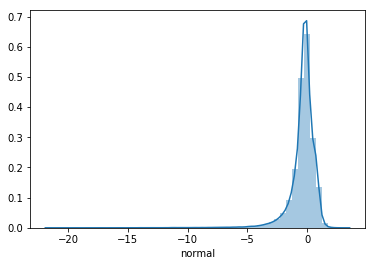

In [132]:
sns.distplot(t1.normal)

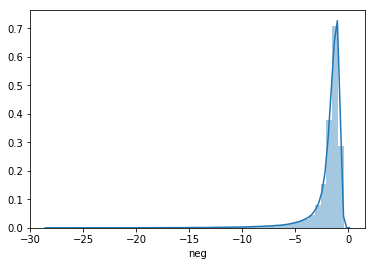

In [133]:
sns.distplot(t1.neg)

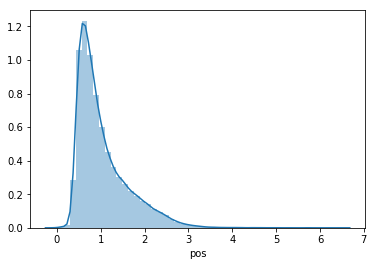

In [134]:
sns.distplot(t1.pos)

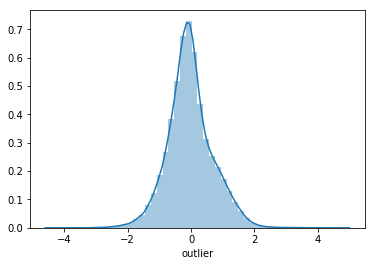

In [135]:
sns.distplot(t1.outlier)

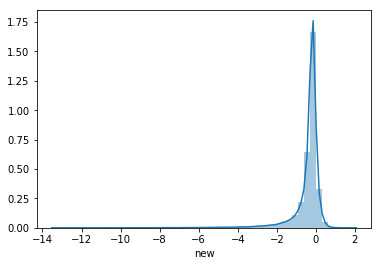

In [136]:
sns.distplot(t1.new)

# 이상치 예측 모델

In [138]:
target = train['outliers']

## 제거할 피처

In [139]:
FEATS_EXCLUDED = ['first_active', 'card_id', 'target', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 
                  'new_purchase_date_max', 'new_purchase_date_min']

## 파라미터

In [140]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 2333}

In [141]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train))
predictions_lgb_log = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb_log += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(log_loss(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0439393	valid_1's binary_logloss: 0.0466941
[200]	training's binary_logloss: 0.0439582	valid_1's binary_logloss: 0.0466935
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.0439586	valid_1's binary_logloss: 0.0465615
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0439916	valid_1's binary_logloss: 0.0471326
[200]	training's binary_logloss: 0.044006	valid_1's binary_logloss: 0.0471322
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.0439602	valid_1's binary_logloss: 0.0470829
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0444197	valid_1's binary_logloss: 0.046345
[200]	training's binary_logloss: 0.0443985	valid_1's binary_logloss: 0.046319
[300]	training's binary_logloss: 0.0443899	valid_1's binary_logloss: 0.0462997
[400]	tra

In [142]:
outlier_prob = pd.DataFrame({"card_id":test["card_id"].values})
outlier_prob["target"] = predictions_lgb_log

# Combining

In [143]:
model_without_outliers = pd.DataFrame({"card_id":test["card_id"].values})
model_without_outliers["target"] = predictions_lgb_without_outliers

In [166]:
outlier_id = pd.DataFrame(outlier_prob.sort_values(by='target',ascending = False).head(200)['card_id'])

In [160]:
t1 = t1.set_index(test.card_id.values)

In [161]:
t1 = t1.reset_index()

In [162]:
t1.columns = ['card_id', 'normal', 'neg', 'pos', 'outlier', 'new']

In [167]:
for v in outlier_id.card_id:
    print(t1[t1.card_id == v][['normal', 'neg', 'pos', 'outlier', 'new']])

          normal        neg       pos  outlier        new
32446 -19.551338 -25.015652  1.433756 -0.18222 -11.790948
          normal        neg       pos   outlier       new
22650 -13.454734 -12.853212  0.743834 -1.122873 -6.054689
          normal        neg       pos   outlier        new
67665 -17.380549 -23.399879  1.980673  0.506923 -10.709603
           normal        neg       pos   outlier       new
105394 -14.014343 -13.819111  0.881716 -0.937218 -6.468698
          normal        neg       pos   outlier       new
33610 -14.763466 -16.116402  0.834797 -0.747194 -7.640803
          normal        neg       pos   outlier     new
41138 -15.419618 -20.974463  1.686063  0.027103 -9.6442
         normal        neg       pos   outlier      new
23336 -15.11739 -16.043246  1.239305 -1.048192 -7.40197
           normal        neg       pos   outlier       new
109705 -14.067543 -16.777381  0.881053 -1.023589 -7.948164
          normal        neg       pos   outlier       new
24677 -14.584636

           normal        neg      pos   outlier       new
107752 -14.375095 -16.567882  0.64258 -1.203142 -7.962651
          normal        neg       pos   outlier       new
63477 -12.122657 -22.835023  1.954744  1.088635 -10.44014
          normal        neg       pos  outlier       new
117101 -10.61213 -17.405485  1.349071  0.74986 -8.028207
          normal        neg       pos   outlier      new
63189 -13.531019 -18.444299  0.991719 -0.426175 -8.72629
          normal        neg       pos  outlier      new
22430 -11.753752 -16.878647  1.555627  0.32368 -7.66151
         normal       neg       pos   outlier       new
51752 -9.110929 -20.43943  2.378198  1.491076 -9.030616
          normal      neg       pos   outlier       new
23168 -14.402786 -18.8431  0.982873 -0.579784 -8.930114
          normal        neg       pos   outlier       new
23022 -11.591874 -16.045951  0.757435 -0.819013 -7.644258
           normal        neg       pos   outlier        new
108111 -16.586536 -24.255934

          normal        neg       pos   outlier        new
76303 -14.746477 -23.579936  1.703331  0.522765 -10.938303
         normal       neg       pos   outlier       new
61930 -9.819118 -13.56434  0.672712 -0.548388 -6.445814
         normal        neg       pos   outlier       new
59438 -10.07932 -17.507452  2.172384  1.064217 -7.667534
           normal        neg       pos   outlier       new
108678 -12.401197 -19.391207  2.106996  0.763365 -8.642106
         normal        neg       pos   outlier       new
80980 -7.697289 -11.913264  1.304167  0.107133 -5.304548
          normal        neg       pos   outlier       new
94668 -12.927277 -18.981574  1.344536 -0.034377 -8.818519
         normal        neg       pos   outlier       new
59340 -9.777366 -18.210949  1.646959  0.765643 -8.281995
         normal        neg       pos   outlier       new
97925 -8.515063 -20.068535  1.951646  1.095857 -9.058444
        normal        neg       pos   outlier       new
13324 -7.44704 -11.64682

In [165]:
for card_id in outlier_id.card_id:
    model_without_outliers.loc[model_without_outliers['card_id'] == card_id, 'target'] = t1.loc[t1['card_id'] == card_id, 'normal']

In [168]:
for card_id in outlier_id.card_id:
    model_without_outliers.loc[model_without_outliers['card_id'] == card_id, 'target'] = (t1.loc[t1['card_id'] == card_id, 'normal'] + t1.loc[t1['card_id'] == card_id, 'neg']) / 2

In [169]:
model_without_outliers.to_csv("./data/submission_combining_neg.csv", index=False)

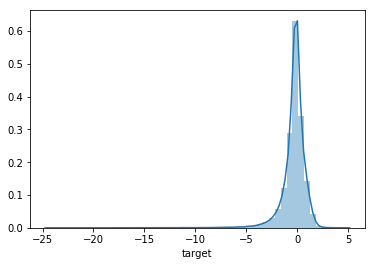

In [171]:
sns.distplot(model_without_outliers.target)